# Backpropagation Lab





In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split as tts, GridSearchCV as GCV, RandomizedSearchCV as RCV
!pip install arff
from scipy.io import arff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm 
import pprint

import warnings
warnings.filterwarnings('ignore')

## 1. (40%) Correctly implement and submit your own code for the backpropagation algorithm. 

## Code requirements 
- Ability to create a network structure with at least one hidden layer and an arbitrary number of nodes.
- Random weight initialization with small random weights with mean of 0 and a variance of 1.
- Use Stochastic/On-line training updates: Iterate and update weights after each training instance (i.e. do not attempt batch updates)
- Implement a validation set based stopping criterion.
- Shuffle training set at each epoch.
- Option to include a momentum term

You may use your own random train/test split or use the scikit-learn version if you want.

Use your Backpropagation algorithm to solve the Debug data. We provide you with several parameters, and you should be able to replicate our results every time. When you are confident it is correct, run your script on the Evaluation data with the same parameters, and print your final weights.

In [2]:
class MLPClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, hidden_layer_widths=[4], lr=.1, momentum=0, shuffle=True,deterministic=1000,zeros=False):
        self.hidden_layer_widths = hidden_layer_widths
        self.lr = lr
        self.momentum = momentum
        self.shuffle = shuffle
        self.successive_accuracies = [] # VS
        self.successive_mean_squared_errors = [] # VS
        self.training_successive_accuracies = [] # training
        self.training_successive_mean_squared_errors = [] # training
        self.zeros = zeros
        self.deterministic = deterministic
        
        self.sig = lambda x: 1/(1+np.exp(-x))
        self.delta = lambda x: x*(1-x)
        self.error = lambda x,y: (y-x)*(self.delta(x))
        
        if deterministic is not None:
            self.shuffle = False

    def initialize_weights(self, n):
        weights = []
        s = self.hidden_layer_widths[0]
        weights.append(np.random.normal(0,1,size = (s,n+1)) * (1 - self.zeros))
        weights.append(np.random.normal(0,1,size = (self.n_classes,s+1)) * (1 - self.zeros))
        return weights
    

    def fit(self, X, y, initial_weights=None, split=0.8, epochs = 100, n_iter_no_change=5):
        if self.shuffle:
                X, y = self._shuffle_data(X, y)
        if split < 0 or 1 < split:
            raise ValueError('split should be between 0, and one')
        if split != 1:
            train_num_rows = int(np.rint(X.shape[0] * split))
            train = X[:train_num_rows].copy()
            train_targets = y[:train_num_rows].copy()
            test_X = X[train_num_rows:].copy()
            test_y = y[train_num_rows:].copy()
        else:
            train = X.copy()
            train_targets = y.copy()
            test_X = X.copy()
            test_y = y.copy()

        X = train
        y = train_targets
        #vs for validation set
        self.test_X = test_X
        self.test_y = test_y
        
        self.X_f = X
        self.y_f = y
        m,n = X.shape
        countdown = 0
        
        self.n_classes = len(np.unique(y))
        classes = list(np.unique(y))
        target = np.zeros((m, self.n_classes))
        for i,yy in enumerate(y):
            target[i, classes.index(yy)] = 1
        if self.hidden_layer_widths == None:
            self.hidden_layer_widths = [n*2,self.n_classes+1]
        else:
            self.hidden_layer_widths.append(self.n_classes+1)
        
        self.initial_weights = self.initialize_weights(n) if not initial_weights else initial_weights
        weights = self.initial_weights
        X = np.hstack((X,np.reshape(np.ones_like(X[:,0]),(-1,1))))
        
        prev_delt = [[],[]]
        prev_delt[0] = np.zeros_like(weights[0])
        prev_delt[1] = np.zeros_like(weights[1])
        for i in range(epochs):
            print(f'Fit epoch: {i}', end='\r')
            if countdown >= n_iter_no_change:
                break
            if self.shuffle:
                X, y = self._shuffle_data(X,y)
                
            for j in range(m):
                a = [[],[]]
                delt = [[],[]]
                #forward pass
                for k in range(weights[0].shape[0]):
                    a[0].append(self.sig(np.dot(X[j], weights[0][k])))
                a[0].append(1)
                for k in range(weights[1].shape[0]):
                    a[1].append(self.sig(np.dot(a[0], weights[1][k])))
                #backward pass
                for k in range(target[1].shape[0]):
                    delt[1].append((target[j][k]-a[1][k]) * a[1][k] * (1-a[1][k]))
                for k in range(weights[0].shape[0]+1):
                    delt[0].append(a[0][k]*(1-a[0][k]) * np.dot(weights[1][:,k],delt[1]))
                #update weights
                for k in range(weights[1].shape[0]):
                    weights[1][k] += self.lr * delt[1][k] * np.array(a[0]) + prev_delt[1][k] * self.momentum
                    prev_delt[1][k] = self.lr * delt[1][k] * np.array(a[0]) + prev_delt[1][k] * self.momentum
                for k in range(weights[0].shape[0]):
                    weights[0][k] += self.lr * delt[0][k] * X[j] + prev_delt[0][k] *self.momentum
                    prev_delt[0][k] = self.lr * delt[0][k] * X[j] + prev_delt[0][k] *self.momentum
            self.weights = weights
            self.training_successive_accuracies.append(self.score(X,y, False))
            self.training_successive_mean_squared_errors.append(self.score_mse(X,y, False))
            self.successive_accuracies.append(self.score(test_X,test_y))
            self.successive_mean_squared_errors.append(self.score_mse(test_X,test_y))
            if len(self.training_successive_accuracies) > 2 and self.training_successive_accuracies[-1] <= self.training_successive_accuracies[-2]:
                countdown += 1
            else:
                countdown = 0
                
        print('                                          ', end='\r')
        return self

    def predict(self, X):
        results = []
        for i in range(X.shape[0]):
            a = [[],[]]
            for k in range(self.weights[0].shape[0]):
                a[0].append(self.sig(np.dot(X[i], self.weights[0][k])))
            a[0].append(1)
            for k in range(self.weights[1].shape[0]):
                a[1].append(self.sig(np.dot(a[0], self.weights[1][k])))
            results.append(np.argmax(a[1]))
        return results

    def score_mse(self, X, y, add_bias=True, debug=False):
        if add_bias:   
            X = np.hstack((X,np.reshape(np.ones_like(X[:,0]),(-1,1))))
        prediction = self.predict(X)
        mse = np.mean((y != prediction)**2)
        if debug:
            print(y)
            print(prediction)
            print(mse)
            
        return mse
    
    def score(self, X, y, add_bias=True):
        if add_bias:   
            X = np.hstack((X,np.reshape(np.ones_like(X[:,0]),(-1,1))))
        prediction = self.predict(X)
        return np.mean(prediction == y)
    
    
    def _shuffle_data(self, X, y):
        z = np.column_stack([X,y])
        np.random.shuffle(z)
        new_X = z[:,:-1]
        new_y = z[:,-1]
        return new_X, new_y

    def get_weights(self):
        return self.weights

## 1.1 

Debug and Evaluate your model using the following parameters:

Learning Rate = 0.1\
Momentum = 0.5\
Deterministic = 10 [This means run it 10 epochs and should be the same everytime you run it]\
Shuffle = False\
Validation size = 0\
Initial Weights = All zeros\
Hidden Layer Widths = [4]

---

### 1.1.1 Debug 

Debug your model by running it on the [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/linsep2nonorigin.arff)


Expected Results for Binary Classification (i.e. 1 output node): [debug_bp_0.csv](https://github.com/cs472ta/CS472/blob/master/debug_solutions/debug_bp_0.csv) 

$$ \text{Layer 1} = \begin{bmatrix} -8.81779797\text{e}-05 & -8.81779797\text{e}-05 & -8.81779797\text{e}-05 & -8.81779797\text{e}-05 \\ 7.82757731\text{e}-04 & 7.82757731\text{e}-04 & 7.82757731\text{e}-04 & 7.82757731\text{e}-04 \\ -3.94353645\text{e}-03 & -3.94353645\text{e}-03 & -3.94353645\text{e}-03 & -3.94353645\text{e}-03 \end{bmatrix}$$
                                             
$$ \text{Layer 2} = \begin{bmatrix} -0.01060888 \\ -0.01060888 \\ -0.01060888 \\ -0.01060888 \\ -0.02145495 \end{bmatrix}$$

(The weights do not need to be in this order or shape.)

Expected Results for One Hot Vector Classification (i.e. 2 output nodes): [debug_bp_2outs.csv](https://github.com/cs472ta/CS472/blob/master/debug_solutions/debug_bp_2outs.csv) 

$$ \text{Layer 1} = \begin{bmatrix} -0.00018149 & -0.00018149 & -0.00018149 & -0.00018149 \\ 0.00157468 & 0.00157468 & 0.00157468 & 0.00157468 \\ -0.00788218 & -0.00788218 & -0.00788218 & -0.00788218 \end{bmatrix}$$
                          
$$ \text{Layer 2} = \begin{bmatrix} 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.02148778 & -0.02148778 \end{bmatrix}$$

(The weights do not need to be in this order or shape.)

In [6]:


data = pd.DataFrame(arff.loadarff('datasets/linsep2nonorigin.arff')[0], dtype=float)
x = data.drop(columns='class').values
y = data['class'].values
mlp = MLPClassifier(hidden_layer_widths=[4], shuffle=False, momentum=.5, lr=.1, zeros=True)
mlp.fit(x,y, epochs=10)
w1,w2 = mlp.get_weights()
print('layer_1:\n',w1)
print('layer_2:\n',w2)

NameError: name 'MLPClassifier' is not defined

### 1.1.2 Evaluation

We will evaluate your model based on it's performance on the [Evaluation Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/data_banknote_authentication.arff)

In [4]:
# Load evaluation data
data = pd.DataFrame(arff.loadarff('datasets/data_banknote_authentication.arff')[0], dtype=float)
x = data.drop(columns=['class']).values
y = data['class'].values
# Train on debug data
mlp = MLPClassifier(shuffle=False)
mlp.fit(x,y)
# Check score
print('score\n', mlp.score_mse(x,y))

score                                     
 0.008017492711370262


## 2. (10%) Backpropagation on the Iris Classification problem.

Load the Iris Dataset [Iris Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff)

Parameters:
- One layer of hidden nodes with the number of hidden nodes being twice the number of inputs.
- Use a 80/20 split of the data for the training/test set.
- Use a learning rate of 0.1
- Use a validation set (15% of the training set) taken from the training set for your stopping criteria
- Create one graph with MSE (mean squared error) over epochs from the training set and validation set
- Create one graph with classification accuracy (% classified correctly) over epochs from the training set and validation set
- Print out your test set accuracy

The results for the different measurables should be shown with a different color, line type, etc. Typical backpropagation accuracies for the Iris data set are 85-95%.

---

In [5]:
iris = load_iris()
X = iris['data']
print()
y = iris['target']
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.20, random_state=42)
mlp = MLPClassifier(lr=.1, hidden_layer_widths=[X.shape[1]*2])
mlp.fit(X_train, y_train, split=.85)
print('score\n',mlp.score(X_test, y_test)*100, '%')
MSE_vals_train = mlp.training_successive_mean_squared_errors
MSE_vals_test = mlp.successive_mean_squared_errors
acc_train = mlp.successive_accuracies
acc_test = mlp.training_successive_accuracies


score                                     
 86.66666666666667 %


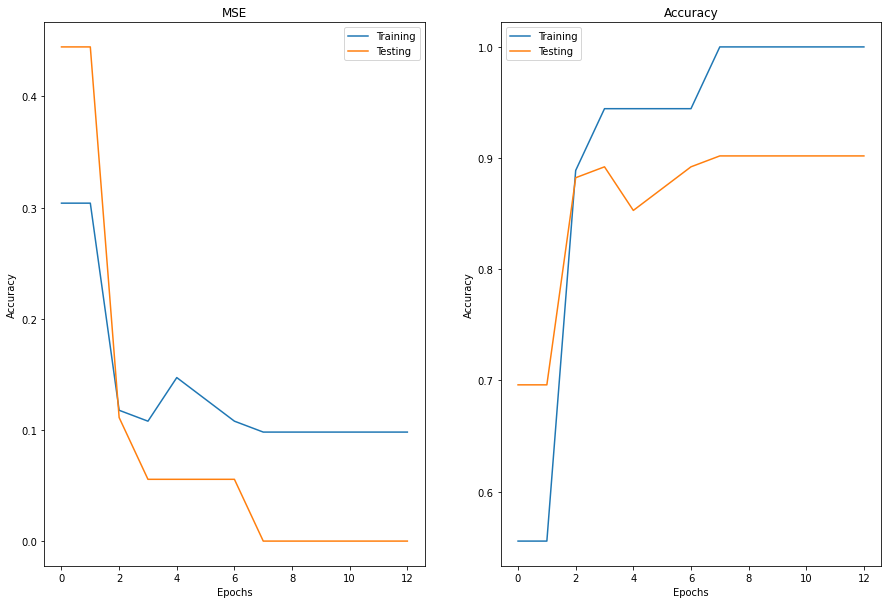

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
                               
ax1.plot(MSE_vals_train, label='Training')
ax1.plot(MSE_vals_test, label='Testing')
ax2.plot(acc_train, label='Training')
ax2.plot(acc_test, label='Testing')
ax1.legend()
ax1.set_title('MSE')
ax2.set_title("Accuracy")
ax1.set_ylabel('Accuracy')
ax1.set_xlabel("Epochs")
ax2.set_ylabel('Accuracy')
ax2.set_xlabel("Epochs")
ax2.legend()
plt.show()

## 3. (10%) Working with the Vowel Dataset - Learning Rate

Load the Vowel Dataset [Vowel Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/vowel.arff)

- Use one layer of hidden nodes with the number of hidden nodes being twice the number of inputs.
- Use random 80/20 splits of the data for the training/test set.
- Use a validation set (15% of the training set) taken from the training set for your stopping criteria
- Try some different learning rates (LR). Note that each LR will probably require a different number of epochs to learn. 

- For each LR you test, plot their validation's set MSE over Epochs on the same graph. Graph 4-5 different LRs and make them different enough to see a difference between them.

In general, whenever you are testing a parameter such as LR, # of hidden nodes, etc., test values until no more improvement is found. For example, if 20 hidden nodes did better than 10, you would not stop at 20, but would try 40, etc., until you no longer get improvement.

If you would like you may average the results of multiple initial conditions (e.g. 3) per LR, and that obviously would give more accurate results.

<img src=https://raw.githubusercontent.com/cs472ta/CS472/master/images/backpropagation/backprop_val_set_MSE_vs_epochs.png width=500 height=500  align="left">

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:09<00:58,  9.80s/it]

 29%|██▊       | 2/7 [02:18<03:47, 45.54s/it]

 43%|████▎     | 3/7 [04:32<04:47, 71.94s/it]

 57%|█████▋    | 4/7 [04:41<02:39, 53.05s/it]

 71%|███████▏  | 5/7 [06:54<02:34, 77.08s/it]

 86%|████████▌ | 6/7 [09:06<01:33, 93.60s/it]

100%|██████████| 7/7 [11:24<00:00, 97.77s/it] 

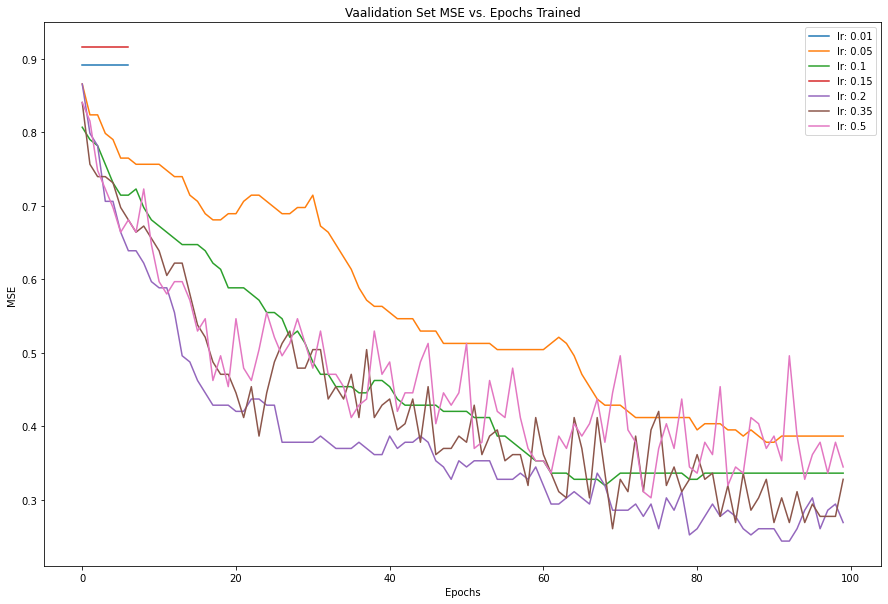

Best Learning Rate: 0.2


In [7]:
data = pd.DataFrame(arff.loadarff('datasets/vowel.arff')[0], dtype=float)
mapper = {}
for c in ['Train or Test', 'Speaker Number','Sex','Class']:
    classes = data[c].unique()
    for i,k in enumerate(classes):
        mapper[k] = i
data = data.replace(mapper)
data = data.drop(columns=['Train or Test'])
X = data.drop(columns='Class').values
y = data['Class'].values

X_train, X_test, y_train, y_test = tts(X, y, test_size=0.20, random_state=42)


LRs = [.01, .05, .1, .15, .2, .35, .5]
MSE_test, best_lr_scores = [], []
fig = plt.figure(figsize=(15,10))
for lr in tqdm(LRs):
    mlp = MLPClassifier(lr=lr, hidden_layer_widths=[X.shape[1]*2])
    mlp.fit(X_train, y_train, split=.85)
    acc_test = mlp.successive_mean_squared_errors
    best_lr_scores.append(np.mean(acc_test))
    plt.plot(acc_test, label=f'lr: {lr}')
plt.title("Validation Set MSE vs. Epochs Trained")
plt.ylabel('MSE')
plt.xlabel("Epochs")
plt.legend()
plt.show()

print(f'Best Learning Rate: {LRs[np.argmin(best_lr_scores)]}')

## 3.1 (5%) Working with the Vowel Dataset - Intuition
- Discuss the effect of varying learning rates. 
- Discuss why the vowel data set might be more difficult than Iris
    - Report both datasets' baseline accuracies and best **test** set accuracies. 
- Consider which of the vowel dataset's given input features you should actually use (Train/test, speaker, gender, ect) and discuss why you chose the ones you did.

Typical backpropagation accuracies for the Vowel data set are above 75%.



The best learning rates are usually between quick and slow moving rates. This allows the machine to learn fast enough to get to a low error. 


## 3.2 (10%) Working with the Vowel Dataset - Hidden Layer Nodes

Using the best LR you discovered, experiment with different numbers of hidden nodes.

- Start with 1 hidden node, then 2, and then double them for each test until you get no more improvement in accuracy. 
- For each number of hidden nodes find the best validation set solution (in terms of validation set MSE).  
- Create one graph with MSE for the training set and validation set on the y-axis and # of hidden nodes on the x-axis.
- Report the final test set accuracy for every # of hidden nodes you experimented on

7.58% Accuracy for 1 Hidden Nodes         
23.23% Accuracy for 2 Hidden Nodes        
31.82% Accuracy for 4 Hidden Nodes        
51.01% Accuracy for 8 Hidden Nodes        
49.49% Accuracy for 16 Hidden Nodes       
56.57% Accuracy for 32 Hidden Nodes       
63.13% Accuracy for 64 Hidden Nodes       
55.56% Accuracy for 128 Hidden Nodes      
47.98% Accuracy for 256 Hidden Nodes      
Best Number of Hidden Nodes was 64


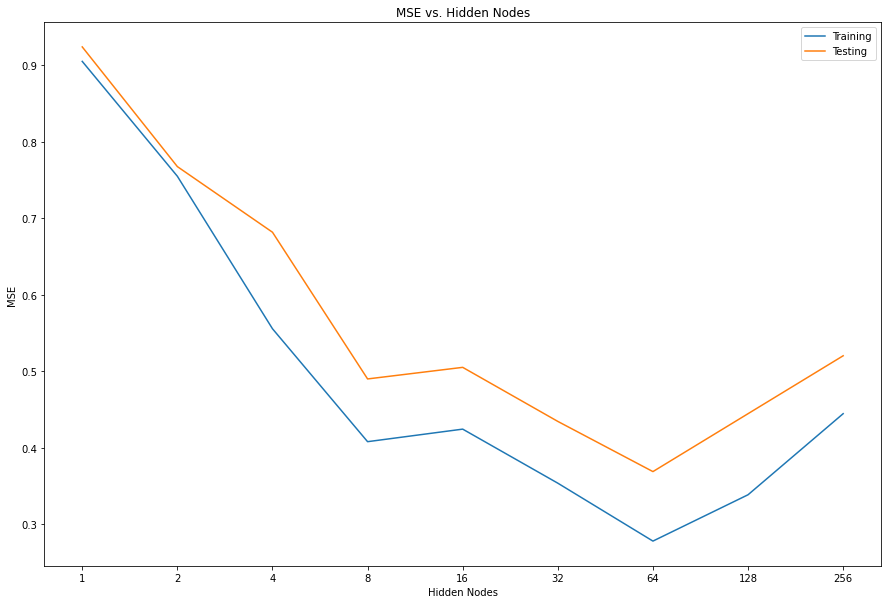

In [8]:
lr = LRs[np.argmin(best_lr_scores)]
train_MSE, test_MSE = [], []
acc_ls = []
Hidden_nodes = []
Hidden_nodes_str = []
count = 0 
for i in range(10):
    if count > 2:
        break
    mlp = MLPClassifier(lr=lr, hidden_layer_widths=[2**i])
    mlp.fit(X_train, y_train, epochs=50)
    train_MSE.append(mlp.score_mse(X_train, y_train))
    test_MSE.append(mlp.score_mse(X_test, y_test))
    acc_ls.append(mlp.score(X_test, y_test))
    Hidden_nodes_str.append(str(2**i))
    Hidden_nodes.append(2**i)
    print(f"{acc_ls[-1]*100:.2f}% Accuracy for {2**i} Hidden Nodes")
    if len(acc_ls) > 1 and acc_ls[-1] < acc_ls[-2]:
        count += 1

print(f"Best Number of Hidden Nodes was {Hidden_nodes[np.argmax(acc_ls)]}")
    
fig = plt.figure(figsize=(15,10))
plt.plot(train_MSE, label='Training')
plt.plot(test_MSE, label='Testing')
plt.xticks(range(len(train_MSE)), Hidden_nodes_str)
plt.title(f"MSE vs. Hidden Nodes")
plt.ylabel('MSE')
plt.xlabel("Hidden Nodes")
plt.legend()
plt.show()

## 3.3 (10%) Working with the Vowel Dataset - Momentum

Try some different momentum terms using the best number of hidden nodes and LR from your earlier experiments.

- Create a graph similar to step 3.2, but with momentum on the x-axis and number of epochs until validation set convergence on the y-axis.
- You are trying to see how much momentum speeds up learning. 

57.58% Accuracy for a Momentum of 0.001   
57.07% Accuracy for a Momentum of 0.005   
60.10% Accuracy for a Momentum of 0.025   
7.58% Accuracy for a Momentum of 0.125    
Best Momentum was 0.025


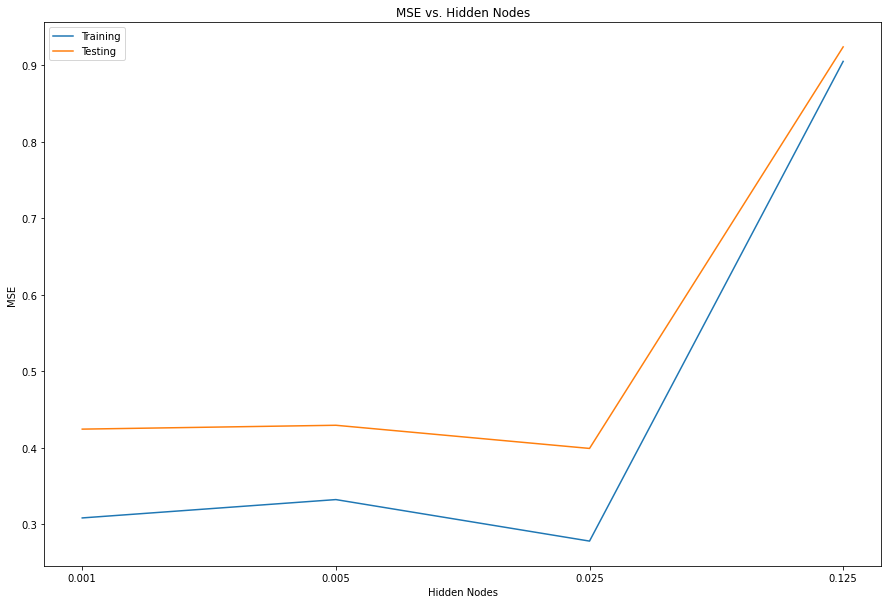

In [10]:
train_score, test_score = [], []
nodes = [64]
i = 0.001
count = 0
train_MSE = []
test_MSE = []
acc_ls = []
momentum_ls = []
while count != 2:
    mlp = MLPClassifier(lr=lr, hidden_layer_widths=nodes, momentum=i)
    mlp.fit(X_train, y_train, epochs = 50)
    train_MSE.append(mlp.score_mse(X_train, y_train))
    test_MSE.append(mlp.score_mse(X_test, y_test))
    acc_ls.append(mlp.score(X_test, y_test))
    momentum_ls.append(i)
    print(f"{acc_ls[-1]*100:.2f}% Accuracy for a Momentum of {i}")
    i += i*4
    if len(acc_ls) > 1 and acc_ls[-1] < acc_ls[-2]:
        count += 1

print(f"Best Momentum was {momentum_ls[np.argmax(acc_ls)]}")
    
fig = plt.figure(figsize=(15,10))
plt.plot(train_MSE, label='Training')
plt.plot(test_MSE, label='Testing')
plt.xticks(range(len(train_MSE)), momentum_ls)
plt.title(f"MSE vs. Hidden Nodes")
plt.ylabel('MSE')
plt.xlabel("Hidden Nodes")
plt.legend()
plt.show()

*Discuss Momentum here*



## 4.1 (10%) Use the scikit-learn (SK) version of the MLP classifier on the Iris and Vowel data sets.  

You do not need to go through all the steps above, nor graph results. Compare results (accuracy and learning speed) between your version and theirs for some selection of hyper-parameters. Try different hyper-parameters and comment on their effect.

At a minimum, try

- number of hidden nodes and layers
- different activation functions
- learning rate
- regularization and parameters
- momentum (and try nesterov)
- early stopping

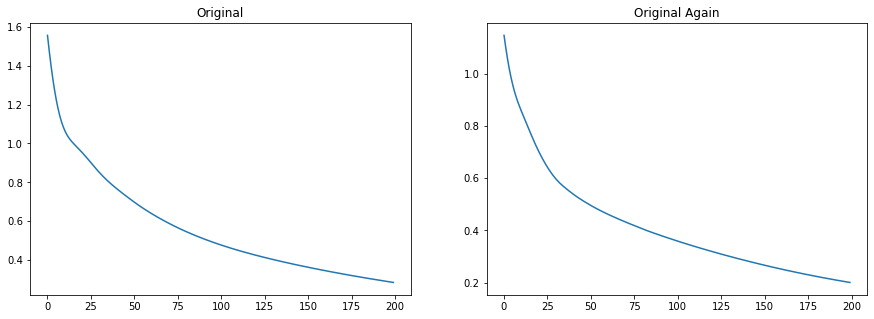

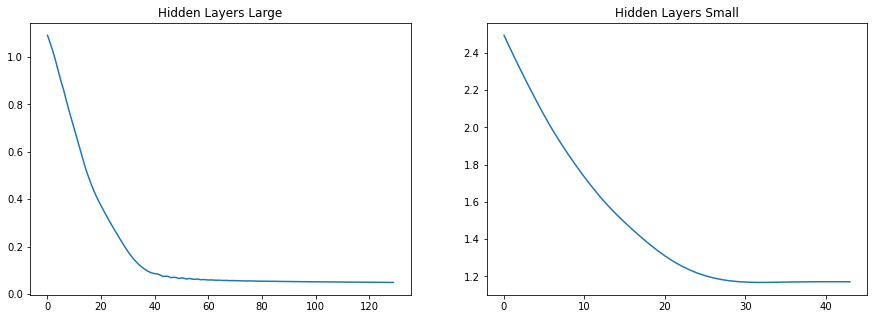

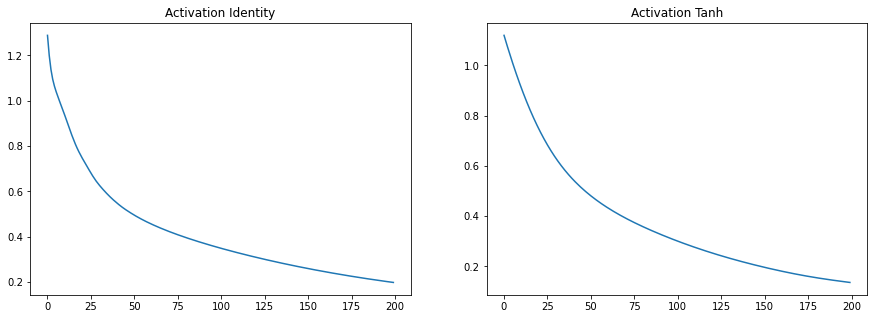

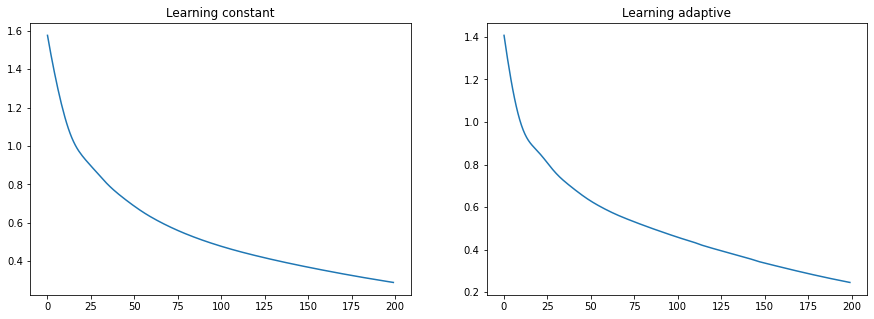

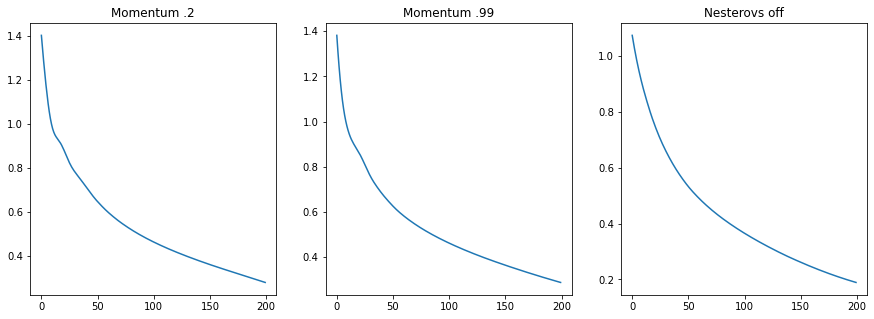

In [11]:
iris = load_iris()
X = iris['data']
y = iris['target']
models = [[MLP(), MLP()],
          [MLP(hidden_layer_sizes=[200,300,10,400]), MLP(hidden_layer_sizes=[10,20,10,3])],
          [MLP(activation='identity'), MLP(activation='tanh')],
          [MLP(learning_rate='constant'), MLP(learning_rate='adaptive')],
          [MLP(momentum=.2), MLP(momentum=.99), MLP(nesterovs_momentum=False)]]
titles = [['Original', 'Original Again'],
          ['Hidden Layers Large', 'Hidden Layers Small'],
          ['Activation Identity','Activation Tanh'],
          ['Learning constant','Learning adaptive'],
          ['Momentum .2','Momentum .99','Nesterovs off']]

for model,title in zip(models, titles):
    fig, axes = plt.subplots(1,len(model), figsize=(15,5))
    axes = axes.flatten()
    for m,t,ax in zip(model, title, axes):
        m.fit(X,y)
        ax.plot(m.loss_curve_)
        ax.set_title(t)
    plt.show()

I think it is definitely simplier to use, but seems pretty much similar.

## 4.2 (5%) Using the Iris Dataset automatically adjust hyper-parameters using your choice of grid/random search
- Use a grid or random search approach across a reasonable subset of hyper-parameters from the above 
- Report your best accuracy and hyper-parameters. 

In [12]:
mlp_param = {
    'hidden_layer_sizes': [[200,200],[100,200,300,400],[400,300,200,100]],
    'activation': ['logistic', 'tanh', 'relu'],
    'learning_rate_init': [.0001, .1],
    'shuffle': [True, False],
    'tol': [1e-2, 1e-7],
    'momentum': [.01,.99],
    'n_iter_no_change': [2,10]
}

clf = GCV(MLP(),mlp_param)
iris = load_iris()
X = iris['data']
y = iris['target']
clf.fit(X,y)
print(clf.best_params_)

{'activation': 'tanh', 'hidden_layer_sizes': [200, 200], 'learning_rate_init': 0.0001, 'momentum': 0.01, 'n_iter_no_change': 2, 'shuffle': False, 'tol': 1e-07}


## 5. (Optional 5% Extra credit) For the vowel data set, use the other hyper-parameter approach that you did not use in part 4.2 to find LR, # of hidden nodes, and momentum.  

- Compare and discuss the values found with the ones you found in part 3.


In [13]:
# Train vowel dataset
data = pd.DataFrame(arff.loadarff('datasets/vowel.arff')[0], dtype=float)
# Fix the data file
mapper = {}
for c in ['Train or Test', 'Speaker Number','Sex','Class']:
    classes = data[c].unique()
    for i,k in enumerate(classes):
        mapper[k] = i
data = data.replace(mapper)
X_train = data[data['Train or Test'] == 0].drop(columns='Class').values
y_train = data[data['Train or Test'] == 0]['Class'].values
X_test = data[data['Train or Test'] == 1].drop(columns='Class').values
y_test = data[data['Train or Test'] == 1]['Class'].values
clf = RCV(MLP(), mlp_param)
clf.fit(X_train,y_train)
print(clf.best_params_)

{'tol': 1e-07, 'shuffle': True, 'n_iter_no_change': 10, 'momentum': 0.99, 'learning_rate_init': 0.0001, 'hidden_layer_sizes': [400, 300, 200, 100], 'activation': 'tanh'}


A low momentum and a very small learning rate are best.  The training set is susceptible to small changes in the SGD algorithm to optimize the learning.